# 1 Machine Learning - Baseline

## Baseline

In this notebook I'll try to recreate Authors' results using Python and scikit-learn tools with their default parameters.

To prepare the users-likes matrix I've followed the Authors' instructions using R, then I exported the matrix with the following code:

In [1]:
# write(colnames(sparsematrix), file = "colnames.txt")
# write(rownames(sparsematrix), file = "rownames.txt")
# writeMM(sparsematrix, file = "sparsematrix.txt")

Let's start with imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

from utils import load_user_like_matrix, plot_roc_curve, test_linreg_targets, test_logreg_target

and data reads:

In [3]:
users = pd.read_csv('data/users_trimmed.csv', index_col='userid')

In [4]:
df = load_user_like_matrix()

In [5]:
users

,Unnamed: 0,gender,age,political,ope,con,ext,agr,neu
userid,,,,,,,,,
c6a9a43058c8cc8398ca6e97324c0fae,11,0,47,NaN,-0.31,-0.57,-0.89,0.41,1.17
e557fd2902b857797cb8cec471f201a5,25,0,35,NaN,0.61,-0.12,-0.64,-1.01,-1.50
f9ed42fd1c0e0e1ecd2ba3fdb54ce6fa,35,1,29,0.0,-0.31,-0.94,-0.77,-1.76,1.05
eca69bfad8f4f2b193b2592248101b7f,39,1,28,0.0,-0.68,0.54,-0.52,-1.01,-0.51
1e4e4517e035a0d5f6dd5bfd1fe65890,53,0,35,NaN,-0.41,-0.86,-1.02,-0.18,0.30
...,...,...,...,...,...,...,...,...,...
3995772c890538007229320216aec92f,110696,1,23,NaN,-0.31,-1.97,-1.21,-1.09,1.79
f9a122ccb0ae03e0e67a6024f46d38d9,110700,1,26,1.0,1.26,0.17,1.11,0.12,0.18
8a1c71c937b9a01c6983d86a4396a240,110707,1,20,NaN,-0.04,0.69,0.17,0.82,0.80


Finally let's load Authors' original results:

In [6]:
results = pd.read_csv('results/authors_results.csv', index_col='name')
results

,age,ope,con,ext,agr,neu,gender,political
name,,,,,,,,
Kosinski_SVD,0.61,0.44,0.26,0.30,0.24,0.29,0.94,0.88
Kosinski_LDA,0.68,0.42,0.22,0.25,0.18,0.24,0.88,0.84


I want to establish a baseline with default scikit-learn values for SVD, LDA and estimators. I'm setting: 
- <i>k</i> to 50 in both SVD and LDA, like the Authors did
- random_state to 42 in order to ensure consistent results
- n_jobs to -1 to speed up calculations
- rest is left untouched

Like the Authors I will also perform 10-fold Cross Validation to test default models and score them using their metrics: AUC for binary classification and Pearson product-moment correlation for linear predictions.

## SVD - Singular Value Decomposition

Because our data is contained in a 19742 by 8523 sparse matrix, I want to reduce it's dimentionality, so that my computer can handle the ML operations in a reasonable time.<br> 

For the baseline predictions I'm using the same number of dimensions (<i>k</i>) as the Authors - 50.<br>
Random state is set to 42.<br>
Other settings are left to their defaults.

In [7]:
svd_50 = TruncatedSVD(n_components=50, random_state=42)

In [8]:
svd_50.fit(df)

TruncatedSVD(n_components=50, random_state=42)

In [9]:
svd_50.explained_variance_ratio_

array([0.06842395, 0.0321085 , 0.0106316 , 0.00899892, 0.00708867,
       0.00650366, 0.0055078 , 0.00478283, 0.00457361, 0.00399356,
       0.00384924, 0.00369514, 0.00342712, 0.00283042, 0.00274755,
       0.00267698, 0.0025537 , 0.00245332, 0.00221804, 0.00211586,
       0.0020819 , 0.00197903, 0.00190869, 0.00176732, 0.00169816,
       0.00168353, 0.0016598 , 0.00161258, 0.00156424, 0.00149546,
       0.00145373, 0.0013966 , 0.0013804 , 0.00134669, 0.00129986,
       0.00128844, 0.00125144, 0.00121984, 0.00119245, 0.00118366,
       0.00117353, 0.00116109, 0.00110642, 0.00109019, 0.0010668 ,
       0.00102228, 0.00099425, 0.00097078, 0.00096766, 0.00096062])

In [10]:
svd_50.explained_variance_ratio_.sum()

0.2221579381725114

In [11]:
print(svd_50.singular_values_)

[635.44467823 378.45856055 200.92848423 182.23536668 160.44161347
 153.68003897 142.40360876 136.21039638 128.89314582 121.05099155
 118.78453159 115.84006547 111.56715945 101.42821344  99.88756531
  99.24832042  96.45096393  94.38774153  89.79686128  88.38104741
  86.95721146  84.79290265  83.43424976  80.15463952  78.60728599
  78.24762971  77.63364223  76.51813028  75.48775521  73.66818284
  72.59774088  71.23528203  70.79483799  69.96024715  68.64341116
  68.30788439  67.3572064   66.45844146  65.66885035  65.45027098
  65.05245826  64.81025132  63.2853144   62.76920437  62.08319207
  60.70579091  59.86011624  59.11194677  59.05178545  58.84646017]


In [12]:
svd_50.get_params

<bound method BaseEstimator.get_params of TruncatedSVD(n_components=50, random_state=42)>

In [13]:
X_svd_50 = svd_50.transform(df)

In [14]:
X_svd_50.shape

(19742, 50)

In [15]:
X_svd_50

array([[ 2.42033159e-01, -4.07786632e-01,  4.61241605e-01, ...,
         6.78477590e-02,  2.84349996e-02, -1.88740492e-01],
       [ 4.30052535e-01, -7.01633009e-01,  5.07358388e-01, ...,
        -4.92988683e-02,  3.15360464e-01,  1.22851373e-01],
       [ 7.20854335e-01, -1.00721159e+00,  1.47106669e-01, ...,
         1.74664155e-01,  2.28317673e-01,  9.38113744e-02],
       ...,
       [ 1.00633148e+00, -1.16654072e+00, -4.49693686e-01, ...,
        -1.16729570e-01,  1.16504449e-01, -3.31053653e-01],
       [ 9.33533483e-01, -1.53535421e+00,  1.32510149e+00, ...,
        -2.02796418e-01,  2.39612464e-03,  8.59464624e-03],
       [ 3.58383916e+00, -5.16269072e+00,  3.37154517e+00, ...,
        -4.16161205e-02,  4.57560174e-01,  3.18388282e-01]])

In [16]:
users.shape

(19742, 9)

### SVD - Machine Learning

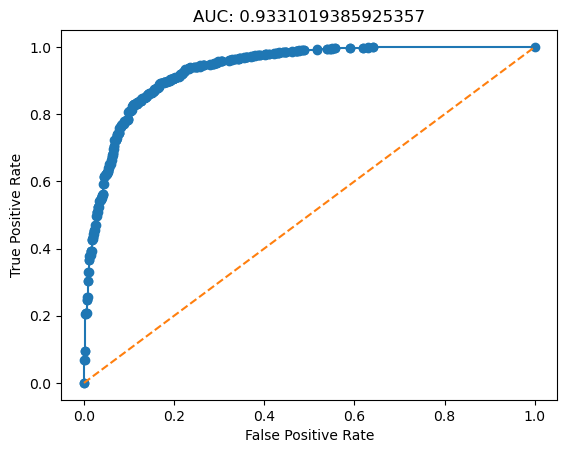

In [17]:
svd_50_gender = test_logreg_target(X_svd_50, users['gender'], 'svd_50_gender')

In [18]:
svd_50_gender

,name,gender
0,svd_50_gender,0.94


In [19]:
baseline_results_svd = test_linreg_targets(X_svd_50, users, 'baseline_results_svd')

In [20]:
baseline_results_svd = pd.concat([baseline_results_svd, svd_50_gender['gender']], axis=1)

In [21]:
baseline_results_svd

,name,age,ope,con,ext,agr,neu,gender
0,baseline_results_svd,0.59,0.43,0.25,0.29,0.23,0.29,0.94


## LDA - Latent Dirichlet Allocation 

Same as the Authors - I'm using <i>k</i> = 50 for LDA dimensionality reduction.

In [22]:
lda_50 = LatentDirichletAllocation(n_components=50, random_state=42)

In [23]:
lda_50.fit(df)

LatentDirichletAllocation(n_components=50, random_state=42)

In [24]:
X_lda_50 = lda_50.transform(df)

In [25]:
X_lda_50.shape

(19742, 50)

### LDA - Machine Learning

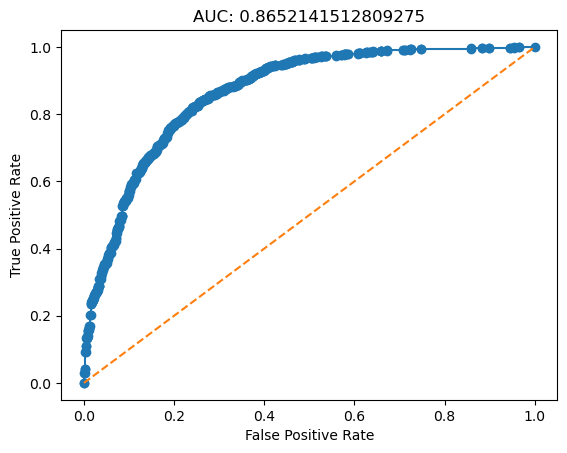

In [26]:
lda_50_gender = test_logreg_target(X_lda_50, users['gender'], 'lda_50_gender')

In [27]:
lda_50_gender

,name,gender
0,lda_50_gender,0.87


In [28]:
baseline_results_lda = test_linreg_targets(X_lda_50, users, 'baseline_results_lda')

In [29]:
baseline_results_lda = pd.concat([baseline_results_lda, lda_50_gender['gender']], axis=1)

In [30]:
baseline_results_lda

,name,age,ope,con,ext,agr,neu,gender
0,baseline_results_lda,0.68,0.37,0.24,0.24,0.16,0.22,0.87


## Results

In [31]:
results

,age,ope,con,ext,agr,neu,gender,political
name,,,,,,,,
Kosinski_SVD,0.61,0.44,0.26,0.30,0.24,0.29,0.94,0.88
Kosinski_LDA,0.68,0.42,0.22,0.25,0.18,0.24,0.88,0.84


In [32]:
baseline_results_svd

,name,age,ope,con,ext,agr,neu,gender
0,baseline_results_svd,0.59,0.43,0.25,0.29,0.23,0.29,0.94


In [33]:
baseline_results_lda

,name,age,ope,con,ext,agr,neu,gender
0,baseline_results_lda,0.68,0.37,0.24,0.24,0.16,0.22,0.87


In [34]:
baseline_results_svd.to_csv('results/baseline_results_svd.csv')
baseline_results_lda.to_csv('results/baseline_results_lda.csv')